## DS340-H Final Capstone Project
Jennifer Ruffin

**_Research Questions_**
1. How does station-level demand (in terms of trip origins  and destinations) vary across different months and times of day?
2. What are the resulting peak usage periods for the most popular stations?

In this notebook, I will employ the machine learning methods Logistic Regression and Random Forests as well as the probabilisitc based regression methods Negative Binomial Regression and Poisson Regression to predict which stations are more likely to be used on a given day. 

In [3]:
import pandas as pd
bikeData = pd.read_csv('/Users/jenniferruffin/Desktop/Capstone/Final/CapstoneFinal.csv')  

In [34]:
bikeData['started_time'] = pd.to_datetime(bikeData['started_time'], errors='coerce')

### Strategy 1: Probabilistc-Based Regression Models for Predicting Start Counts (Poisson and Negative Binomial...thanks MATH/STAT 220!)

Step 1: Impport necessary libraries


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

Step 2: Aggregate data to station-hour level for start counts

In [33]:
hourly_starts = bikeData.groupby(['start_station_name', 'startmonth', 'start_hour', 'start_day_of_week']).size().reset_index(name='start_count')
hourly_starts = hourly_starts.rename(columns={'start_hour': 'hour','startmonth': 'month', 'start_day_of_week': 'day_of_week'})

Step 3: Defining and Encoding predictors and target variable

_Because I had categorical predictors, I decided to encode them so running the models would be easier_

In [7]:
categorical_cols = ['start_station_name', 'month', 'day_of_week']
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    hourly_starts[col + '_encoded'] = encoders[col].fit_transform(hourly_starts[col])

# Add hour as a predictor
hourly_starts['hour_of_day'] = hourly_starts['hour']

# defining predictors and target
predictors = ['start_station_name_encoded', 'month_encoded', 'day_of_week_encoded',
                   'hour_of_day'] # Add more predictors if available
target = 'start_count'

Step 4: Split data into testing and training data

In [8]:
# Split data
train_p, test_p = train_test_split(hourly_starts, test_size=0.2, random_state=0)

Step 5: Run Regressions

- Block 1: Poisson
- Block 2: Negative Binomial

In [10]:
# Poisson
formula = f"{target} ~ " + " + ".join(predictors)
poisson_model = smf.glm(formula=formula, data=train_p, family=sm.families.Poisson()).fit()

print(poisson_model.summary())

# Make predictions 
predictions_poisson = poisson_model.predict(test_p)
print("\nPoisson Regression Predictions (first 10):")
print(predictions_poisson.head(10))

# Evaluate predictions, using mean absolute error here
from sklearn.metrics import mean_absolute_error
mae_poisson = mean_absolute_error(test_p[target], predictions_poisson.round()) # Round predictions to integers
print(f"Poisson Regression Mean Absolute Error: {mae_poisson}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:            start_count   No. Observations:                 2527
Model:                            GLM   Df Residuals:                     2522
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32954.
Date:                Wed, 09 Apr 2025   Deviance:                       53235.
Time:                        01:05:50   Pearson chi2:                 5.22e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9992
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [11]:
# Negative Binomial Regression
negativebinomial_model = smf.glm(formula=formula, data=train_p,
                                  family=sm.families.NegativeBinomial()).fit()

print("\nNegative Binomial Regression Summary:")
print(negativebinomial_model.summary())

predictions_nb = negativebinomial_model.predict(test_p)
mae_nb = mean_absolute_error(test_p[target], predictions_nb.round())
print(f"Negative Binomial Regression Mean Absolute Error: {mae_nb}")


Negative Binomial Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:            start_count   No. Observations:                 2527
Model:                            GLM   Df Residuals:                     2522
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11534.
Date:                Wed, 09 Apr 2025   Deviance:                       1794.1
Time:                        01:05:53   Pearson chi2:                 1.39e+03
No. Iterations:                    13   Pseudo R-squ. (CS):             0.2589
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Given the outputs of both the Poisson and NBinom Models, the NBinom is established to be the better model for predicting. Now, I will visualize what the model's predictions are.

First, I will import the necessary libraries for data visualizations in Python

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

A dataframe that contained all predictions was created to be used for the visualizations

In [26]:
month_values = test_p['month_encoded'].unique()
hour_values = range(24)

mean_start_station = train_p['start_station_name_encoded'].mean()
mean_day_of_week = train_p['day_of_week_encoded'].mean()

prediction_data = pd.DataFrame({
    'month_encoded': np.repeat(month_values, len(hour_values)),
    'hour_of_day': np.tile(hour_values, len(month_values)),
    'start_station_name_encoded': mean_start_station,
    'day_of_week_encoded': mean_day_of_week
})

In [27]:
# Predicting start counts using the model
predicted_counts = negativebinomial_model.predict(prediction_data)
prediction_data['predicted_start_count'] = predicted_counts

Time to visualize!

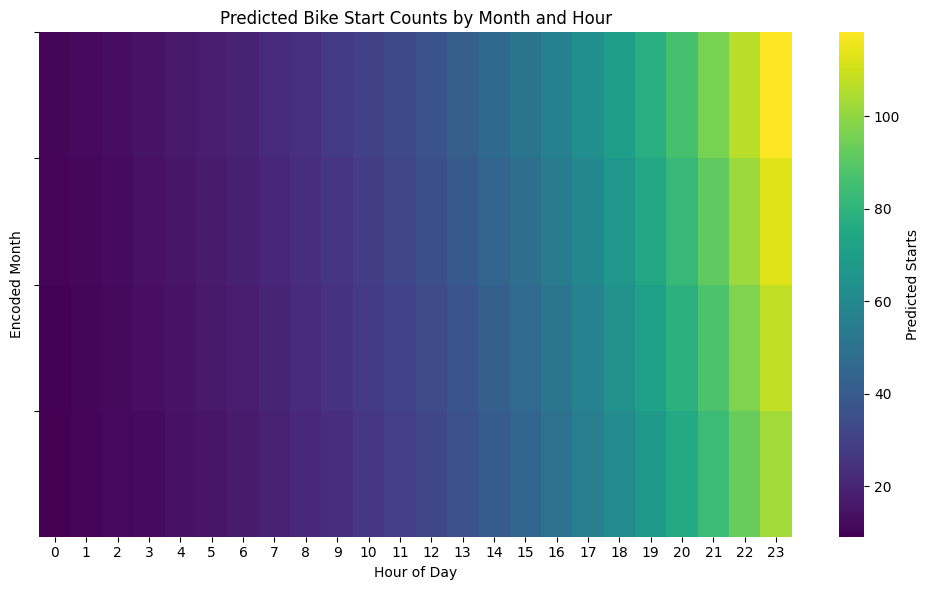

In [63]:
# Visualization 1: Heatmap of predicted start counts by month and hour

# created pivot table to format data into a 2D format for the heatmap() function in seaborn
pivot_table = prediction_data.pivot_table(
    values='predicted_start_count',
    index='month_encoded',
    columns='hour_of_day'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=False, cmap='viridis', cbar_kws={'label': 'Predicted Starts'})
plt.title('Predicted Bike Start Counts by Month and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Encoded Month')
plt.yticks(sorted(test_p['month_encoded'].unique())) # Ensure proper month labels if needed
plt.tight_layout()
plt.show()


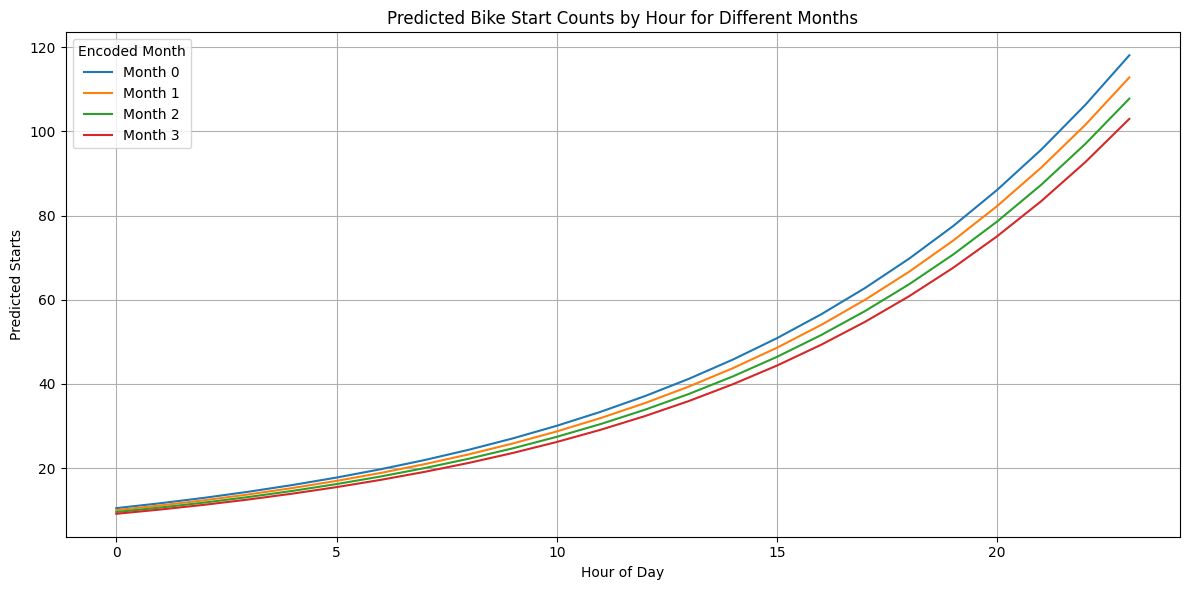

In [30]:
# Visualization 2: Line plots of predicted start counts by hour for different months
plt.figure(figsize=(12, 6))
for month in sorted(test_p['month_encoded'].unique()):
    subset = prediction_data[prediction_data['month_encoded'] == month]
    plt.plot(subset['hour_of_day'], subset['predicted_start_count'], label=f'Month {month}') 

plt.xlabel('Hour of Day')
plt.ylabel('Predicted Starts')
plt.title('Predicted Bike Start Counts by Hour for Different Months')
plt.legend(title='Encoded Month')
plt.grid(True)
plt.tight_layout()
plt.show()

### Strategy 2: Predicting Peak Usage Times with ML Strategies Logistic Regression and Random Forests

Step 1: Import necessary libraries 

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

Step 2: Aggregate hourly start counts for each station

In [39]:
hourly_station_usage = bikeData.groupby(['start_station_name', 'start_hour','start_day_of_week','startmonth']).size().reset_index(name='hourly_starts')
hourly_station_usage = hourly_station_usage.rename(columns={'start_hour': 'hour','start_day_of_week': 'day_of_week', 'startmonth': 'month'})

Step 3: Defining a threshold for **"high usage"** 

_For this context, we will look at the top 10% of hourly counts for each station_

In [40]:
def define_hourly_high_usage(df, percentile=0.9):
    df['hourly_threshold'] = df.groupby('start_station_name')['hourly_starts'].transform(lambda x: x.quantile(percentile)) # CS 315 help, lambda
    df['is_peak'] = (df['hourly_starts'] >= df['hourly_threshold']).astype(int)
    df = df.drop(columns=['hourly_threshold'])
    return df

hourly_usage_with_peak = define_hourly_high_usage(hourly_station_usage.copy()) # copied to not modify original dataframe


Step 4: Encoding and Defining Predictors -- similar to strategy 1

In [41]:
categorical_cols_peak = ['start_station_name', 'month', 'day_of_week']
encoders_peak = {}
for col in categorical_cols_peak:
    encoders_peak[col] = LabelEncoder()
    hourly_usage_with_peak[col + '_encoded'] = encoders_peak[col].fit_transform(hourly_usage_with_peak[col])

# Define predictors and target
predictors_peak = ['start_station_name_encoded', 'month_encoded', 'day_of_week_encoded', 'hour']
target_peak = 'is_peak'

Step 5: Splitting data into testing and training

In [54]:
train_peak, test_peak = train_test_split(hourly_usage_with_peak, test_size=0.2, random_state=0)

Step 5: Run Models

- Block 1: Logistic Regression
- Block 2: Random Forests

In [30]:
# Logistic Regression
model_peak = LogisticRegression(random_state=42)
model_peak.fit(train_peak[predictors_peak], train_peak[target_peak])

# Make predictions
predictions_peak_lr = model_peak.predict(test_peak[predictors_peak])

# Evaluate
print("\nLogistic Regression for Peak Usage Prediction:")
print("Accuracy:", accuracy_score(test_peak[target_peak], predictions_peak_lr))
print("Classification Report:\n", classification_report(test_peak[target_peak], predictions_peak_lr))


Logistic Regression for Peak Usage Prediction:
Accuracy: 0.8876582278481012
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       561
           1       0.00      0.00      0.00        71

    accuracy                           0.89       632
   macro avg       0.44      0.50      0.47       632
weighted avg       0.79      0.89      0.83       632



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [58]:
# Random Forests
rf_peak = RandomForestClassifier(random_state=42)
rf_peak.fit(train_peak[predictors_peak], train_peak[target_peak])

# Make predictions
predictions_peak_rf = rf_peak.predict(test_peak[predictors_peak])

# Evaluate
print("\nRandom Forest for Peak Usage Prediction:")
print("Accuracy:", accuracy_score(test_peak[target_peak], predictions_peak_rf))
print("Classification Report:\n", classification_report(test_peak[target_peak], predictions_peak_rf))


Random Forest for Peak Usage Prediction:
Accuracy: 0.935126582278481
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       561
           1       0.77      0.61      0.68        71

    accuracy                           0.94       632
   macro avg       0.86      0.79      0.82       632
weighted avg       0.93      0.94      0.93       632

